## Installs

In [ ]:
!pip install darts

In [ ]:
# # Uncomment this if you use Colab and have the repo in your local drive
# from google.colab import drive
# drive.mount('/content/drive')
# from pathlib import Path

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

from tqdm import tqdm_notebook as tqdm

import matplotlib.pyplot as plt
import matplotlib.dates as md
%matplotlib inline
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler, StaticCovariatesTransformer
from darts.models import TFTModel
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression

from pytorch_lightning.callbacks import TQDMProgressBar
import torch
import dill

import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)

import os
from pprint import pprint
from datetime import datetime, timedelta

In [ ]:
os.chdir('Electricity Maps')

In [ ]:
FILE = "./data/DK-DK2.csv"
TARGET = 'carbon_intensity_avg'
TIME_COLUMN = 'datetime'
MODEL_PATH = 'tft_model.pt'

#Configure the lookback period and the forecast horizon. Use hours.
input_chunk_length = 24*3
forecast_horizon = 24

The model should predict 24 hours of `carbon_intensity_avg` according to multiple covariate variables and as well as its own past values. 

The idea is for the model to support several categorical columns such as `production mode` and `zone_name`.


Approach:

1.   Data:


> * check **missing data**. It might be that for some features the missing data might not be distributed uniformely at random, but in fact cover larger periods of time. This often happens when support for a new data stream is implemented -- before that point, we'll not see values for it.
> * check **missing target data**. Usually this data cannot be used in a straight forward way neither for training, nor evaluation.
> * check for other weird stuff like several data points for the same timestamp
> * **imputation of missing values**. Take the simplest approach and use the last variable. Probably a form of interpolation would be better, but it can be that when there is a strong seasonality this method is not adviceable.
> * **multicollinearity**. Try to correct for it as it can make estimates vague, imprecise and unreliable.

2.   Model:
> * the darts package was used as it supports various models (which one could evaluate more easily given more time)
> * a very simple maive baseline in which one simply outputs data for the past 24 hours is used
> * the more advancenced model used was Temporal Fusion Transformer due to the following:
>> * Support for temporal aspect
>> * Support for covariate variable(s) (time series, but also static)
>> * Support for quantile predictions (vs just point estimates)
>> * Some support for interpretability (though this was not explored in this case)
>> * The resulting data is comprised by 3 slices of multivariate time series. Due to the lack of time, we treat each of these separately (split each in 80/20 for train and validation). A MinMax scaler is used separately for each slice.
>> * No hyperparam optimization is done due to lack of time


3. Evaluation:
> * MAPE is used for ease of interpretability, though it has issues: it's asymmetric and can yield null or infinite values. SMAPE or something similar might be better.
> * Only a single day worth of estimates is evaluated just for illustration. In a real scenario would be pretty much useless (insufficient at least).






In [ ]:
df = pd.read_csv(FILE)

## 1. EDA and feature engineering

Remove any completely empty columns.

For the rest that are above 10%, see how they are distributed.

In [ ]:
def get_missing_value_columns(df):
  pct_missing = (df.isnull().sum() / df.shape[0] * 100.00).to_frame().reset_index()
  pct_missing.columns = ['feature', 'pct_null']

  empty_columns = pct_missing[pct_missing['pct_null']==100].feature.values
  display(pct_missing[~pct_missing['feature'].isin(empty_columns)].sort_values(by='pct_null', ascending=False).head(20))
  return empty_columns, pct_missing

In [ ]:
empty_columns, pct_missing = get_missing_value_columns(df)
print(f'Completely empty columns: {empty_columns}')

,feature,pct_null
55,latest_forecasted_precipitation_avg,40.615759
57,latest_forecasted_temperature_avg,39.964705
54,latest_forecasted_dewpoint_avg,39.819231
56,latest_forecasted_solar_avg,29.490604
58,latest_forecasted_wind_x_avg,29.459601
59,latest_forecasted_wind_y_avg,29.459601
61,latest_forecasted_production_avg,1.733759
68,latest_forecasted_production_wind_avg,1.504817
67,latest_forecasted_production_solar_avg,1.504817
64,latest_forecasted_power_net_import_DK-DK1_avg,1.447582


Completely empty columns: ['carbon_intensity_discharge_avg' 'total_storage_avg'
 'total_discharge_avg' 'power_production_hydro_avg'
 'power_production_nuclear_avg' 'power_production_geothermal_avg'
 'power_production_unknown_avg' 'power_net_discharge_hydro_avg'
 'power_net_import_SE-SE4_avg' 'latest_forecasted_power_net_import_SE_avg']


In [ ]:
df.drop(columns=empty_columns, inplace=True)

In [ ]:
index_unique = df.drop_duplicates(subset=list(set(df.columns)-set(['datetime', 'timestamp', 'zone_name'])), keep='last').index
duplicates = df[~df.index.isin(index_unique)]

empty_columns, pct_missing = get_missing_value_columns(duplicates)
print(f'Completely empty columns: {empty_columns}')

,feature,pct_null
51,latest_forecasted_price_avg,95.918367
0,datetime,0.000000
1,timestamp,0.000000
2,zone_name,0.000000


Completely empty columns: ['carbon_intensity_avg' 'carbon_intensity_production_avg'
 'carbon_intensity_import_avg' 'carbon_rate_avg' 'total_production_avg'
 'total_import_avg' 'total_export_avg' 'total_consumption_avg'
 'production_sources' 'power_origin_percent_fossil_avg'
 'power_origin_percent_renewable_avg' 'power_production_biomass_avg'
 'power_production_coal_avg' 'power_production_gas_avg'
 'power_production_oil_avg' 'power_production_solar_avg'
 'power_production_wind_avg' 'power_consumption_biomass_avg'
 'power_consumption_coal_avg' 'power_consumption_gas_avg'
 'power_consumption_hydro_avg' 'power_consumption_nuclear_avg'
 'power_consumption_oil_avg' 'power_consumption_solar_avg'
 'power_consumption_wind_avg' 'power_consumption_geothermal_avg'
 'power_consumption_unknown_avg' 'power_consumption_hydro_discharge_avg'
 'carbon_origin_percent_biomass_avg' 'carbon_origin_percent_coal_avg'
 'carbon_origin_percent_gas_avg' 'carbon_origin_percent_hydro_avg'
 'carbon_origin_percent_nuc

In [ ]:
#Drop rows with empty target
df.drop(index=duplicates.index, inplace=True)

In [ ]:
df.timestamp = pd.to_datetime(df.timestamp, unit='s').dt.strftime('%Y-%m-%d %H-%M-%S')
df.timestamp = pd.to_datetime(df.timestamp)
df.datetime = pd.to_datetime(df.datetime).dt.strftime('%Y-%m-%d %H-%M-%S')
df.datetime = pd.to_datetime(df.datetime)

In [ ]:
#Check if there is anything else except exact hour 
assert len(df.timestamp.dt.minute.unique())==1
assert len(df.timestamp.dt.second.unique())==1

#Check if there are any delays between the requested time and the ingestion time
assert (df.datetime-df.timestamp).dt.total_seconds().max() == 0

#Check if there are several timestamps per datetime
assert df[['datetime', 'timestamp']].groupby(by='datetime').count()['timestamp'].max() == 1

In [ ]:
#Check if there are any gaps between the dates
complete_time_range = pd.date_range(start=df.datetime.min(), end=df.datetime.max(), freq='H')

assert(set(complete_time_range) - set(df.datetime) == set(), pprint(set(complete_time_range) - set(df.datetime)))

missing_timestamps = list(set(complete_time_range) - set(df.datetime))

{Timestamp('2014-12-12 07:00:00+0000', tz='UTC', freq='H'),
 Timestamp('2014-12-12 09:00:00+0000', tz='UTC', freq='H'),
 Timestamp('2014-12-12 22:00:00+0000', tz='UTC', freq='H'),
 Timestamp('2014-12-13 00:00:00+0000', tz='UTC', freq='H'),
 Timestamp('2014-12-13 01:00:00+0000', tz='UTC', freq='H'),
 Timestamp('2014-12-13 02:00:00+0000', tz='UTC', freq='H'),
 Timestamp('2014-12-13 03:00:00+0000', tz='UTC', freq='H'),
 Timestamp('2014-12-13 04:00:00+0000', tz='UTC', freq='H'),
 Timestamp('2014-12-13 05:00:00+0000', tz='UTC', freq='H'),
 Timestamp('2014-12-13 06:00:00+0000', tz='UTC', freq='H'),
 Timestamp('2014-12-13 07:00:00+0000', tz='UTC', freq='H'),
 Timestamp('2014-12-13 08:00:00+0000', tz='UTC', freq='H'),
 Timestamp('2014-12-13 09:00:00+0000', tz='UTC', freq='H'),
 Timestamp('2014-12-13 10:00:00+0000', tz='UTC', freq='H'),
 Timestamp('2014-12-13 11:00:00+0000', tz='UTC', freq='H'),
 Timestamp('2014-12-13 12:00:00+0000', tz='UTC', freq='H'),
 Timestamp('2014-12-13 13:00:00+0000', t

In [ ]:
missing_target_timestamps = list(df[df.carbon_intensity_avg.isna()]['datetime'])
#  dummy = pd.DataFrame(index=complete_time_range)
#  dummy['carbon_intensity_avg'] = 1 

#  dummy[dummy.index.isin(missing_target_timestamps)] = 2
#  dummy[dummy.index.isin(missing_timestamps)] = 3

#  plt.figure(figsize=(20,12))
#  dummy.plot(label='na')
#  plt.show();

In [ ]:
all_missing_timestamps = missing_timestamps+missing_target_timestamps
missing_dates = list(set([x.date() for x in all_missing_timestamps]))

In [ ]:
#Remove periods: 2014-12-11 -- 2014-12-31, 2016-12-15, 2019-05-22 -- 2019-05-23, 2019-07-03--2019-07-04, 2019-09-26

df.drop(df[df['datetime'].dt.date.isin(missing_dates)].index, inplace=True)

In [ ]:
empty_columns, pct_missing = get_missing_value_columns(df)
print(f'Completely empty columns: {empty_columns}')

,feature,pct_null
46,latest_forecasted_precipitation_avg,39.983556
48,latest_forecasted_temperature_avg,39.323370
45,latest_forecasted_dewpoint_avg,39.175856
47,latest_forecasted_solar_avg,28.736216
49,latest_forecasted_wind_x_avg,28.704778
50,latest_forecasted_wind_y_avg,28.704778
52,latest_forecasted_production_avg,0.652931
58,latest_forecasted_production_wind_avg,0.362739
57,latest_forecasted_production_solar_avg,0.362739
55,latest_forecasted_power_net_import_DK-DK1_avg,0.304701


Completely empty columns: []


### For columns with >25% missing values, how are they distributed?

In [ ]:
df.set_index('datetime', inplace=True)

#Which columns have more than 25% missing values?
sparse_columns = list(pct_missing[pct_missing['pct_null']>=25]['feature'])
sparse_df = pd.DataFrame(index=df.index, columns=sparse_columns)

for i in range(len(sparse_columns)):
  idx = df[df[sparse_columns[i]].isna()].index
  sparse_df.loc[idx, sparse_columns[i]] = i+1

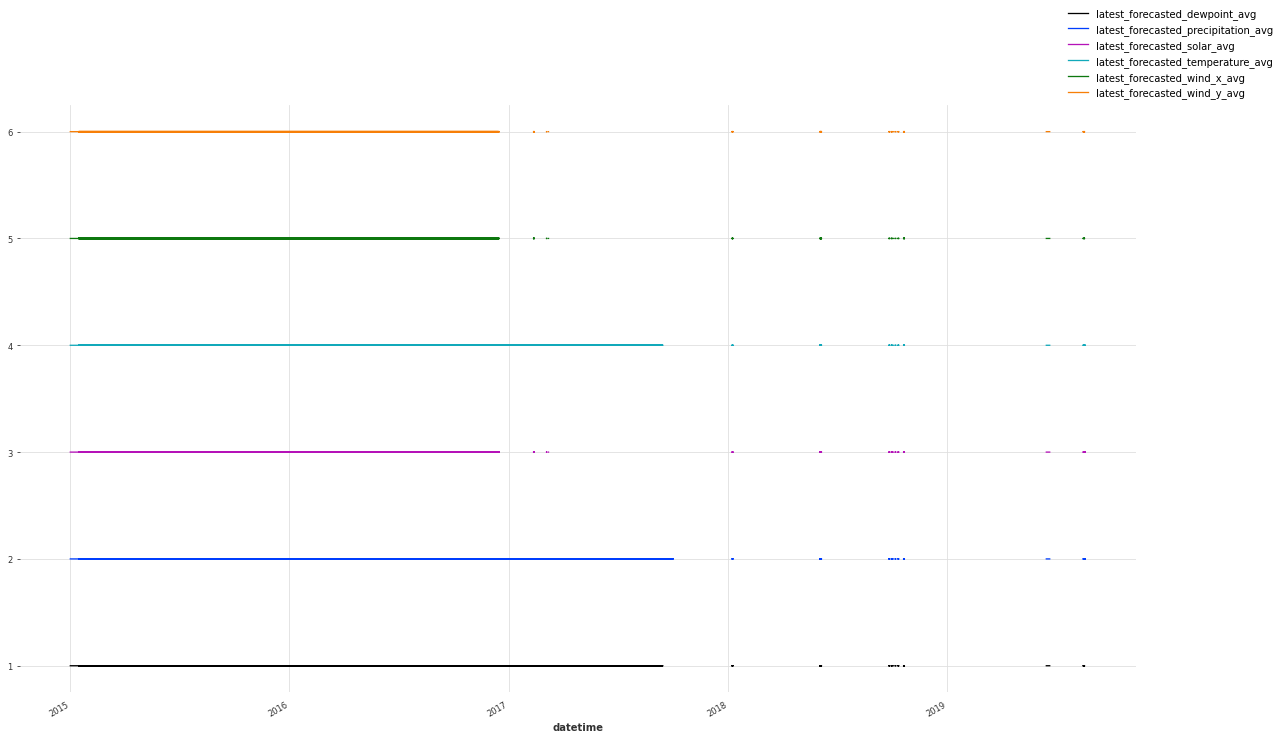

In [ ]:
fig = plt.figure(figsize=(20,12))
for i in range(len(sparse_columns)):
  sparse_df[sparse_columns[i]].plot(label=sparse_columns[i])
#To show this figure object, we use the line,
fig.legend()
fig.show()

### Check for the Granger causality of covariates

The aim is to check if a given covariate has any predictive power over the target (if so, the covariate would be said to Granger cause the target).

Caveat: one assumption is that the series need to be stationary. Most likely this is not the case, so just running the test on the data as it is would not provide trustworthy results.

In [ ]:
# import statsmodels.api as sm
# from statsmodels.tsa.stattools import grangercausalitytests
# for i in range(len(sparse_columns)):
#   sample = df.loc[df[df.index>='2018-10-01'].index][[sparse_columns[i], TARGET]]
#   sample = sample.fillna(method="ffill")
#   print(f'------{sparse_columns[i]}------')
#   print(grangercausalitytests(sample, maxlag=[6]))

### Restrict the data to the most recent and relevant period. Correct any existent multicollinearity

Keep only dates for which we have weather predictions, as we assume that they are useful in the context of electricity generation.

Remove columns which are multicollinear. We do so by succesively removing columns which have a high variance inflation factor.

For the missing values, **very** simply imput the last value.

In [ ]:
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

multicoliniarity_data = df.loc[df[df.index>='2018-10-01'].index].copy(deep=True)
multicoliniarity_data = multicoliniarity_data._get_numeric_data() #drop non-numeric cols
multicoliniarity_data = multicoliniarity_data.fillna(method="ffill")

In [ ]:
#gather features
cols = list(multicoliniarity_data.columns)
cols.remove(TARGET)

ordered_cols = cols + [TARGET]

ordered_cols_orig = ordered_cols.copy()

multicoliniarity_data = multicoliniarity_data[ordered_cols]

ordered_cols = [f'c_{i}' for i in range(len(ordered_cols))]
multicoliniarity_data.columns = ordered_cols
features = " + ".join(ordered_cols[:-1])

# get y and X dataframes based on this regression:
formula = f'{ordered_cols[-1]} ~ {features}'
y, X = dmatrices(formula, multicoliniarity_data, return_type='dataframe')

X_cols_enc = X.columns
y.columns = [TARGET]
X_columns = ['Intercept'] + ordered_cols_orig[:-1]
X.columns = X_columns

In [ ]:
# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif["features_enc"] = X_cols_enc
vif = vif.sort_values(by='VIF Factor').reset_index()

vif.head(100)

,index,VIF Factor,features,features_enc
0,0,0.000000e+00,Intercept,Intercept
1,42,1.306038e+00,latest_forecasted_precipitation_avg,c_41
2,45,1.341263e+00,latest_forecasted_wind_x_avg,c_44
3,46,1.444705e+00,latest_forecasted_wind_y_avg,c_45
4,47,3.350121e+00,latest_forecasted_price_avg,c_46
5,43,3.540062e+00,latest_forecasted_solar_avg,c_42
6,51,7.643162e+00,latest_forecasted_power_net_import_DK-DK1_avg,c_50
7,26,9.823256e+00,power_consumption_hydro_discharge_avg,c_25
8,1,1.269373e+01,carbon_intensity_production_avg,c_0
9,53,2.038683e+01,latest_forecasted_production_solar_avg,c_52


In [ ]:
multicoliniarity_data.columns = ordered_cols
corr = multicoliniarity_data.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,c_0,c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8,c_9,c_10,c_11,c_12,c_13,c_14,c_15,c_16,c_17,c_18,c_19,c_20,c_21,c_22,c_23,c_24,c_25,c_26,c_27,c_28,c_29,c_30,c_31,c_32,c_33,c_34,c_35,c_36,c_37,c_38,c_39,c_40,c_41,c_42,c_43,c_44,c_45,c_46,c_47,c_48,c_49,c_50,c_51,c_52,c_53,c_54
c_0,1.00,0.28,0.64,-0.00,0.06,-0.16,0.20,0.70,-0.70,0.49,0.64,0.45,0.28,-0.29,-0.57,0.53,0.63,0.46,0.16,0.10,0.23,-0.26,-0.56,-0.07,0.22,0.07,-0.02,0.40,-0.14,-0.16,-0.17,-0.21,-0.38,-0.77,-0.27,-0.14,-0.02,-0.04,-0.08,0.15,-0.40,-0.17,-0.31,-0.47,-0.26,0.07,0.54,0.57,0.21,-0.05,-0.07,0.17,-0.28,-0.53,0.68
c_1,0.28,1.00,0.74,0.26,-0.35,-0.14,0.19,0.82,-0.17,0.40,0.33,0.34,0.20,-0.04,-0.04,0.49,0.76,0.58,-0.52,-0.57,0.25,0.08,0.00,0.59,-0.54,0.24,-0.13,0.64,0.06,-0.60,-0.59,-0.19,-0.08,-0.39,0.38,-0.61,0.15,0.65,0.27,-0.65,-0.41,-0.05,-0.13,-0.42,-0.12,0.02,0.20,0.42,0.19,0.65,0.38,-0.61,-0.04,-0.04,0.84
c_2,0.64,0.74,1.00,0.46,-0.17,-0.15,0.63,0.90,-0.30,0.71,0.71,0.69,0.37,-0.10,-0.13,0.80,0.95,0.83,-0.24,-0.43,0.37,-0.02,-0.08,0.22,-0.26,0.27,-0.02,0.63,0.05,-0.56,-0.61,-0.26,-0.21,-0.59,-0.02,-0.59,0.13,0.32,0.29,-0.35,-0.60,-0.10,-0.19,-0.63,-0.16,0.05,0.58,0.79,0.63,0.32,0.33,-0.29,-0.09,-0.11,0.91
c_3,-0.00,0.26,0.46,1.00,-0.40,0.50,0.55,0.21,0.49,0.71,0.64,0.52,0.26,-0.13,0.74,0.55,0.41,0.35,-0.51,-0.64,0.12,-0.17,0.68,-0.14,-0.47,-0.01,0.34,0.34,-0.05,-0.58,-0.58,-0.21,-0.22,0.13,-0.19,-0.60,-0.06,0.03,0.31,-0.54,-0.63,0.05,-0.23,-0.66,0.17,-0.04,0.12,0.73,0.53,0.04,0.32,-0.50,-0.12,0.74,0.31
c_4,0.06,-0.35,-0.17,-0.40,1.00,0.21,0.15,-0.19,-0.34,-0.32,-0.20,-0.06,-0.06,0.15,-0.35,-0.31,-0.17,-0.04,0.60,0.59,-0.05,0.14,-0.28,-0.03,0.50,0.06,-0.39,-0.25,0.15,0.53,0.47,0.08,0.20,-0.10,-0.02,0.48,0.07,-0.17,0.07,0.41,0.34,0.07,0.25,0.34,-0.09,0.11,0.13,-0.25,0.13,-0.17,-0.00,0.41,0.15,-0.33,-0.31
c_5,-0.16,-0.14,-0.15,0.50,0.21,1.00,-0.07,-0.18,0.28,0.20,0.28,0.08,0.01,-0.21,0.56,-0.08,-0.08,-0.19,-0.27,-0.17,-0.18,-0.27,0.42,-0.14,-0.16,-0.18,0.08,0.07,-0.17,-0.10,-0.01,-0.13,-0.21,0.32,-0.08,-0.04,-0.17,-0.15,0.15,-0.32,-0.22,0.11,-0.24,-0.27,0.16,0.04,-0.25,0.22,-0.09,-0.14,0.11,-0.32,-0.21,0.56,-0.15
c_6,0.20,0.19,0.63,0.55,0.15,-0.07,1.00,0.29,0.11,0.52,0.45,0.60,0.30,0.17,0.18,0.57,0.50,0.64,0.10,-0.20,0.30,0.15,0.29,-0.09,-0.04,0.22,0.04,0.18,0.24,-0.23,-0.39,-0.10,0.08,-0.22,-0.21,-0.37,0.15,0.03,0.36,-0.08,-0.37,0.03,0.14,-0.35,-0.00,0.01,0.54,0.59,0.96,0.03,0.34,-0.01,0.18,0.19,0.30
c_7,0.70,0.82,0.90,0.21,-0.19,-0.18,0.29,1.00,-0.52,0.51,0.61,0.56,0.34,-0.16,-0.30,0.60,0.90,0.73,-0.28,-0.36,0.36,-0.06,-0.26,0.39,-0.23,0.21,-0.20,0.70,0.05,-0.55,-0.54,-0.21,-0.25,-0.66,0.14,-0.52,0.09,0.41,0.17,-0.36,-0.48,-0.12,-0.24,-0.53,-0.21,0.07,0.45,0.60,0.30,0.41,0.25,-0.32,-0.16,-0.28,0.97
c_8,-0.70,-0.17,-0.30,0.49,-0.34,0.28,0.11,-0.52,1.00,0.04,-0.18,-0.18,-0.12,0.20,0.76,-0.06,-0.34,-0.27,-0.34,-0.52,-0.15,0.15,0.76,-0.11,-0.43,-0.11,0.42,-0.16,0.01,-0.23,-0.33,0.04,0.23,0.65,0.06,-0.32,-0.04,0.00,0.38,-0.41,-0.04,0.13,0.14,0.02,0.32,-0.08,-0.35,-0.05,0.11,0.01,0.33,-0.38,0.20,0.74,-0.39
c_9,0.49,0.40,0.71,0.71,-0.32,0.20,0.52,0.51,0.04,1.00,0.70,0.59,0.28,-0.27,0.13,0.91,0.61,0.51,-0.28,-0.46,0.16,-0.28,0.10,-0.16,-0.20,0.04,0.56,0.33,-0.16,-0.54,-0.57,-0.36,-0.40,-0.40,-0.32,-0.52,-0.05,-0.01,0.18,-0.30,-0.75,-0.13,-0.36,-0.81,-0.04,0.01,0.45,0.94,0.52,-0.01,0.19,-0.25,-0.27,0.15,0.63


In [ ]:
from joblib import Parallel, delayed
from statsmodels.stats.outliers_influence import variance_inflation_factor

def removeMultiColl(data, vif_threshold = 5.0):
    for i in data.columns:
        if data[i].nunique() == 1:
            print(f"Dropping {i} due to just 1 unique value")
            data.drop(columns = i, inplace = True)
    drop = True
    col_list = list(data.columns)
    while drop == True:
        drop = False
        vif_list = Parallel(n_jobs = -1, verbose = 5)(delayed(variance_inflation_factor)(data[col_list].values, i) for i in range(data[col_list].shape[1]))
        max_index = vif_list.index(max(vif_list))
        if vif_list[max_index] > vif_threshold:
            print(f"Dropping column : {col_list[max_index]} at index - {max_index}")
            del col_list[max_index]
            drop = True
    print("Remaining columns :\n", list(data[col_list].columns))
    return data[col_list]

cleaned = removeMultiColl(multicoliniarity_data[multicoliniarity_data.columns[:-1]], vif_threshold = 5.0)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:    3.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Dropping column : c_3 at index - 3


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  50 out of  53 | elapsed:    2.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  53 out of  53 | elapsed:    2.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Dropping column : c_27 at index - 26


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  52 out of  52 | elapsed:    2.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Dropping column : c_43 at index - 41


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  51 out of  51 | elapsed:    2.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Dropping column : c_6 at index - 5


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Dropping column : c_40 at index - 37


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  46 out of  49 | elapsed:    2.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  49 out of  49 | elapsed:    2.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Dropping column : c_4 at index - 3


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:    2.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Dropping column : c_48 at index - 42


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  47 out of  47 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Dropping column : c_2 at index - 2


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  43 out of  46 | elapsed:    1.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  46 out of  46 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Dropping column : c_8 at index - 4


[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Dropping column : c_39 at index - 33


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  44 out of  44 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Dropping column : c_7 at index - 3


[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  43 out of  43 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Dropping column : c_9 at index - 3


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  42 out of  42 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Dropping column : c_16 at index - 9


[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  41 out of  41 | elapsed:    1.2s finished


Dropping column : c_14 at index - 7


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    1.2s finished


Dropping column : c_17 at index - 8


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Dropping column : c_19 at index - 9


[Parallel(n_jobs=-1)]: Done  38 out of  38 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Dropping column : c_47 at index - 32


[Parallel(n_jobs=-1)]: Done  37 out of  37 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Dropping column : c_20 at index - 9


[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Dropping column : c_35 at index - 22


[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Dropping column : c_49 at index - 30


[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  34 out of  34 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Dropping column : c_0 at index - 0


[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  33 out of  33 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Dropping column : c_22 at index - 9


[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Dropping column : c_28 at index - 13


[Parallel(n_jobs=-1)]: Done  31 out of  31 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Dropping column : c_13 at index - 5


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Dropping column : c_18 at index - 6


[Parallel(n_jobs=-1)]: Done  29 out of  29 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Dropping column : c_15 at index - 5


[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Dropping column : c_46 at index - 23


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Dropping column : c_23 at index - 6


[Parallel(n_jobs=-1)]: Done  26 out of  26 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Dropping column : c_31 at index - 11


[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Dropping column : c_29 at index - 9


[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Dropping column : c_53 at index - 23


[Parallel(n_jobs=-1)]: Done  23 out of  23 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Dropping column : c_52 at index - 22


[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Dropping column : c_1 at index - 0


[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Dropping column : c_50 at index - 19


[Parallel(n_jobs=-1)]: Done  12 out of  20 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Dropping column : c_32 at index - 9


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Dropping column : c_25 at index - 6


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Dropping column : c_51 at index - 17


[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Dropping column : c_26 at index - 6
Remaining columns :
 ['c_5', 'c_10', 'c_11', 'c_12', 'c_21', 'c_24', 'c_30', 'c_33', 'c_34', 'c_36', 'c_37', 'c_38', 'c_41', 'c_42', 'c_44', 'c_45']


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.1s finished


In [ ]:
remaining_cols = ['c_5', 'c_10', 'c_11', 'c_12', 'c_21', 'c_24', 'c_30', 'c_33', 'c_34', 'c_36', 'c_37', 'c_38', 'c_41', 'c_42', 'c_44', 'c_45']
corr[corr.index.isin(remaining_cols)][remaining_cols].style.background_gradient(cmap='coolwarm').set_precision(2)

,c_5,c_10,c_11,c_12,c_21,c_24,c_30,c_33,c_34,c_36,c_37,c_38,c_41,c_42,c_44,c_45
c_5,1.00,0.28,0.08,0.01,-0.27,-0.16,-0.01,0.32,-0.08,-0.17,-0.15,0.15,0.11,-0.24,0.16,0.04
c_10,0.28,1.00,0.53,0.25,-0.30,-0.17,-0.46,-0.39,-0.31,-0.07,-0.05,0.16,-0.07,-0.37,-0.08,0.06
c_11,0.08,0.53,1.00,0.40,-0.12,-0.09,-0.34,-0.33,-0.22,0.00,0.03,0.17,-0.05,-0.18,-0.08,0.06
c_12,0.01,0.25,0.40,1.00,-0.01,-0.06,-0.22,-0.21,-0.08,-0.00,0.05,0.04,-0.03,-0.05,-0.04,0.00
c_21,-0.27,-0.30,-0.12,-0.01,1.00,-0.13,-0.09,-0.08,0.40,0.03,0.35,0.11,-0.04,0.66,-0.02,0.01
c_24,-0.16,-0.17,-0.09,-0.06,-0.13,1.00,0.56,-0.20,-0.35,-0.05,-0.50,-0.36,-0.10,0.06,-0.20,-0.00
c_30,-0.01,-0.46,-0.34,-0.22,-0.09,0.56,1.00,0.21,-0.26,-0.09,-0.40,-0.43,0.05,0.14,-0.06,-0.02
c_33,0.32,-0.39,-0.33,-0.21,-0.08,-0.20,0.21,1.00,0.02,-0.08,-0.19,0.09,0.18,0.07,0.33,-0.06
c_34,-0.08,-0.31,-0.22,-0.08,0.40,-0.35,-0.26,0.02,1.00,0.21,0.75,0.01,0.11,0.17,0.04,0.06
c_36,-0.17,-0.07,0.00,-0.00,0.03,-0.05,-0.09,-0.08,0.21,1.00,0.27,-0.01,0.09,0.09,0.01,0.02


In [ ]:
remaining_cols_dec = [ordered_cols_orig[int(c.split('_')[1])] for c in remaining_cols]
relevant_columns = remaining_cols_dec + ['zone_name', 'production_sources'] + [TARGET]
df_cleaned = df.loc[df[df.index>='2018-10-01'].index].copy(deep=True)
df_cleaned = df_cleaned[relevant_columns]
df_cleaned = df_cleaned.fillna(method="ffill")

Which are the remaining columns?

In [ ]:
remaining_cols_dec

['total_export_avg',
 'power_production_coal_avg',
 'power_production_gas_avg',
 'power_production_oil_avg',
 'power_consumption_solar_avg',
 'power_consumption_unknown_avg',
 'carbon_origin_percent_nuclear_avg',
 'carbon_origin_percent_wind_avg',
 'carbon_origin_percent_geothermal_avg',
 'carbon_origin_percent_hydro_discharge_avg',
 'power_net_import_DE_avg',
 'power_net_import_DK-DK1_avg',
 'latest_forecasted_precipitation_avg',
 'latest_forecasted_solar_avg',
 'latest_forecasted_wind_x_avg',
 'latest_forecasted_wind_y_avg']

Strange that imports from Sweden are not included. We'd probably need to do a more thorough analysis.

In [ ]:
df = df_cleaned.copy(deep=True)

Back up the processed data.

In [ ]:
df['datetime'] = pd.to_datetime(df.index).tz_localize(None)
df.to_csv('./data/processed_data.csv')

In [ ]:
df.head()

,total_export_avg,power_production_coal_avg,power_production_gas_avg,power_production_oil_avg,power_consumption_solar_avg,power_consumption_unknown_avg,carbon_origin_percent_nuclear_avg,carbon_origin_percent_wind_avg,carbon_origin_percent_geothermal_avg,carbon_origin_percent_hydro_discharge_avg,power_net_import_DE_avg,power_net_import_DK-DK1_avg,latest_forecasted_precipitation_avg,latest_forecasted_solar_avg,latest_forecasted_wind_x_avg,latest_forecasted_wind_y_avg,zone_name,production_sources,carbon_intensity_avg,datetime
datetime,,,,,,,,,,,,,,,,,,,,
2018-10-01 00:00:00+00:00,549.10,163.0,26.0,9.0,0.0,58.556992,3.105312,0.997078,0.0,0.0,-549.10,97.05,0.255208,0.0,4.728968,-0.574080,DK-DK2,entsoe.eu,151.354147,2018-10-01 00:00:00
2018-10-01 01:00:00+00:00,585.02,161.0,26.0,9.0,0.0,56.155058,2.984349,1.035611,0.0,0.0,-585.02,159.29,0.046875,0.0,4.859015,-0.477317,DK-DK2,entsoe.eu,149.929259,2018-10-01 01:00:00
2018-10-01 02:00:00+00:00,585.07,165.0,26.0,9.0,0.0,56.409987,2.828644,0.998136,0.0,0.0,-585.07,163.18,0.114583,0.0,4.992228,-0.409915,DK-DK2,entsoe.eu,150.327254,2018-10-01 02:00:00
2018-10-01 03:00:00+00:00,492.87,208.0,26.0,9.0,0.0,58.201751,2.225818,0.791084,0.0,0.0,-492.87,165.45,0.119792,0.0,4.947109,-0.213823,DK-DK2,entsoe.eu,171.513790,2018-10-01 03:00:00
2018-10-01 04:00:00+00:00,54.52,261.0,33.0,11.0,0.0,53.504048,1.193265,0.631272,0.0,0.0,-54.52,293.38,0.307292,0.0,5.265335,-0.643280,DK-DK2,entsoe.eu,230.102548,2018-10-01 04:00:00


## 2. Modelling

### 2.1 Load backed-up cleaned data

In [ ]:
date_cols = ['datetime']
df = pd.read_csv('./data/processed_data.csv', parse_dates=date_cols).drop(columns=['Unnamed: 0'])
df['datetime'] = df['datetime'].dt.tz_localize(None)

cat_cols = list(df.select_dtypes(exclude=[np.number]).columns)
num_cols = list(df.select_dtypes(include=[np.number]).columns)
num_cols.remove(TARGET)
cat_cols.remove(TIME_COLUMN)

In [ ]:
#Check if there are any gaps between the dates
complete_time_range = pd.date_range(start=df.datetime.min(), end=df.datetime.max(), freq='H')

#assert(set(complete_time_range) - set(df.datetime) == set(), pprint(set(complete_time_range) - set(df.datetime)))

missing_timestamps = list(set(complete_time_range) - set(df.datetime))

missing_dates = sorted(list(set([x.date() for x in missing_timestamps])))

print(f'''
START: {df.datetime.min()}
END: {df.datetime.max()}
MISSING: {missing_dates}''')


START: 2018-10-01 00:00:00
END: 2019-09-25 23:00:00
MISSING: [datetime.date(2019, 5, 22), datetime.date(2019, 5, 23), datetime.date(2019, 7, 2), datetime.date(2019, 7, 3), datetime.date(2019, 7, 4)]


### 2.2 Create the Train - Validation splits

Given that we have 2 periods of a couple of missing dates, disregard them and instead use the 3 resulting continuous series.

For each of these series, split them into train and validation.

In [ ]:
#Remove periods with missing targets: 2014-12-11 -- 2014-12-31, 2016-12-15, 2019-05-22 -- 2019-05-23, 2019-07-03--2019-07-04, 2019-09-26
#Only the ones after 2018-10-01 are relevant.

time_period_starts = [df.datetime.min(), pd.Timestamp('2019-05-22'), pd.Timestamp('2019-07-04')]
time_period_ends = [pd.Timestamp('2019-05-21'), pd.Timestamp('2019-07-02'), df.datetime.max()]

covariates = []
target = []
number_of_validation_days = []
training_cutoff = []

for i in range(len(time_period_starts)):
  df_slice = df[df['datetime'].between(time_period_starts[i], time_period_ends[i])]

  number_of_validation_days.append(int(((time_period_ends[i] - time_period_starts[i]).days)*0.2) + 1)
  training_cutoff.append(time_period_ends[i] - timedelta(days=number_of_validation_days[i]))


  covariates.append(TimeSeries.from_group_dataframe(df_slice,
                                         group_cols=cat_cols,
                                         time_col=TIME_COLUMN,
                                         value_cols=num_cols,
                                         freq='H')
  )

  target.append(TimeSeries.from_group_dataframe(df_slice,
                                         group_cols=cat_cols,
                                         time_col=TIME_COLUMN,
                                         value_cols=TARGET,
                                         freq='H')
  )

train_cov, val_cov = [], []
for i in range(len(time_period_starts)):
  crt_train_cov, crt_val_cov = [], []
  for s in covariates[i]:
    train, val = s.split_before(training_cutoff[i]) 
    crt_train_cov.append(train)
    crt_val_cov.append(val)
  train_cov.append(crt_train_cov)
  val_cov.append(crt_val_cov)


train_target, val_target = [], []
for i in range(len(time_period_starts)):
  crt_train_target, crt_val_target = [], []
  for s in target[i]:
    train, val = s.split_before(training_cutoff[i]) 
    crt_train_target.append(train)
    crt_val_target.append(val)
  train_target.append(crt_train_target)
  val_target.append(crt_val_target)

### 2.3 Baseline Naive Seasonal models

Try a simple forecast in which we just predict the last 24 hours.

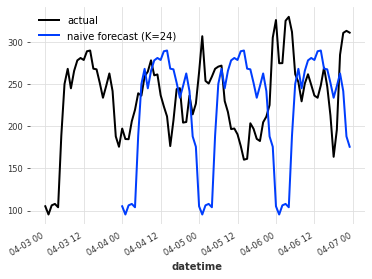

In [ ]:
from darts.models import NaiveSeasonal

naive_model = NaiveSeasonal(K=24)
naive_model.fit(train_target[0][0])
seasonal_forecast = naive_model.predict(24*3)

cutoff = df[df.datetime==training_cutoff[0]].index[0]
target[0][0][cutoff-24:cutoff+24*3].plot(label="actual")
seasonal_forecast.plot(label="naive forecast (K=24)")

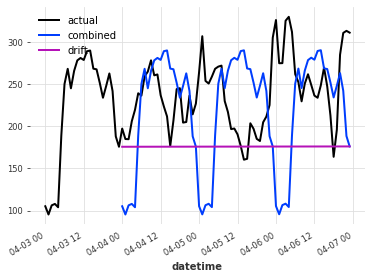

In [ ]:
from darts.models import NaiveDrift

drift_model = NaiveDrift()
drift_model.fit(train_target[0][0])
drift_forecast = drift_model.predict(24*3)

combined_forecast = drift_forecast + seasonal_forecast - train_target[0][0].last_value()

target[0][0][cutoff-24:cutoff+24*3].plot(label="actual")
combined_forecast.plot(label="combined")
drift_forecast.plot(label="drift")

#### 2.3.1 Evaluate the Naive Seasonal Drift baseline

In [ ]:
from darts.metrics import mape

print(
    "Mean absolute percentage error for the combined naive drift + seasonal: {:.2f}%.".format(
        mape(target[0][0][cutoff:cutoff+24*3], combined_forecast)
    )
)

Mean absolute percentage error for the combined naive drift + seasonal: 30.08%.


### 2.4. More advanced model: Temporal fusion transformer

In [ ]:
encoders={
    'cyclic': {'future': ['month']},
    'datetime_attribute': {'future': ['hour', 'dayofweek']},
    'position': {'past': ['relative'], 'future': ['relative']},
    'custom': {'past': [lambda idx: (idx.year - 2018) / 50]},
    'transformer': Scaler()
}

# default quantiles for QuantileRegression
quantiles = [
    0.01,
    0.05,
    0.1,
    0.15,
    0.2,
    0.25,
    0.3,
    0.4,
    0.5,
    0.6,
    0.7,
    0.75,
    0.8,
    0.85,
    0.9,
    0.95,
    0.99,
]
input_chunk_length = 24*3
forecast_horizon = 24

my_model = TFTModel(
    input_chunk_length=input_chunk_length,
    output_chunk_length=forecast_horizon,
    hidden_size=64,
    lstm_layers=1,
    num_attention_heads=4,
    dropout=0.1,
    batch_size=16,
    n_epochs=50,
    add_relative_index=False,
    add_encoders=encoders,
    likelihood=QuantileRegression(
        quantiles=quantiles
    ),  # QuantileRegression is set per default
    # loss_fn=MSELoss(),
    random_state=42,
)

Scale the variables.

In [ ]:
train_cov_scaled, val_cov_scaled, cov_scaled = [], [], []
scalers = []

for i in range(len(time_period_starts)):
  scaler = Scaler() # The categorical and numerical columns are infered otherwise
  train_cov_scaled.append(scaler.fit_transform(train_cov[i]))
  scalers.append(scaler)
  cov_scaled.append(scaler.transform(covariates[i]))
  val_cov_scaled.append(scaler.transform(val_cov[i]))

Check that the variables are indeed scaled.

Plot an example of a given covariate and then its' scaled version.

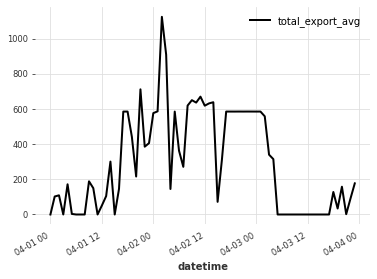

In [ ]:
train_cov[0][0]['total_export_avg'][-24*3:].plot()

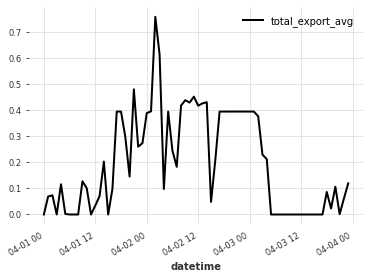

In [ ]:
train_cov_scaled[0][0]['total_export_avg'][-24*3:].plot()

Scale the target -- actually this is only to encode the categorical column.

In [ ]:
train_target_scaled, target_scaled, val_target_scaled = [], [], []

for i in range(len(time_period_starts)):
  scaler_target = StaticCovariatesTransformer(cols_cat=cat_cols) # The categorical and numerical columns are infered otherwise
  train_target_scaled.append(scaler_target.fit_transform(train_target[i]))
  target_scaled.append(scaler_target.transform(target[i]))
  val_target_scaled.append(scaler_target.transform(val_target[i]))

In [ ]:
# fit the model with past covariates
my_model.fit(series=train_target_scaled[0],
    past_covariates=cov_scaled[0][0],
    verbose=True
)

Training: 0it [00:00, ?it/s]

In [ ]:
torch.save(my_model, MODEL_PATH, pickle_module=dill)

In [ ]:
loaded_model = torch.load(MODEL_PATH, pickle_module=dill)

In [ ]:
# before starting, we define some constants
num_samples = 200

figsize = (9, 6)
lowest_q, low_q, high_q, highest_q = 0.01, 0.1, 0.9, 0.99
label_q_outer = f"{int(lowest_q * 100)}-{int(highest_q * 100)}th percentiles"
label_q_inner = f"{int(low_q * 100)}-{int(high_q * 100)}th percentiles"

Predicting: 272it [00:00, ?it/s]

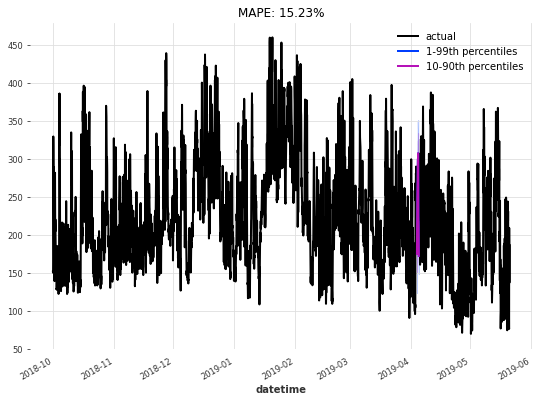

In [ ]:
def eval_model(model, n, train_target, val_target, target, past_covariates):
    pred_series = model.predict(n=n, num_samples=num_samples, series=train_target, past_covariates=past_covariates)

    # plot actual series
    plt.figure(figsize=figsize)
    target.plot(label="actual")

    # plot prediction with quantile ranges
    pred_series.plot(
        low_quantile=lowest_q, high_quantile=highest_q, label=label_q_outer
    )
    pred_series.plot(low_quantile=low_q, high_quantile=high_q, label=label_q_inner)

    
    plt.title("MAPE: {:.2f}%".format(mape(val_target, pred_series)))
    plt.legend()


eval_model(my_model, 24, train_target_scaled[0][0], val_target_scaled[0][0], target_scaled[0][0], train_cov_scaled[0][0])

Predicting: 272it [00:00, ?it/s]

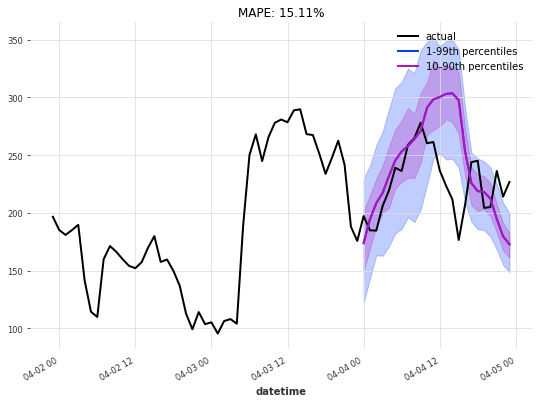

In [ ]:
def eval_model(model, n, train_target, val_target, target, past_covariates):
    pred_series = model.predict(n=n, num_samples=num_samples, series=train_target, past_covariates=past_covariates)

    # plot actual series
    plt.figure(figsize=figsize)
    target[train_target.end_time()-timedelta(days=2):train_target.end_time()+timedelta(days=1)].plot(label="actual")

    # plot prediction with quantile ranges
    pred_series[train_target.end_time():train_target.end_time()+timedelta(days=1)].plot(
        low_quantile=lowest_q, high_quantile=highest_q, label=label_q_outer
    )
    pred_series[train_target.end_time():train_target.end_time()+timedelta(days=1)].plot(low_quantile=low_q, high_quantile=high_q, label=label_q_inner)

    
    plt.title("MAPE: {:.2f}%".format(mape(val_target, pred_series)))
    plt.legend()


eval_model(my_model, 24, train_target_scaled[0][0], val_target_scaled[0][0], target_scaled[0][0], train_cov_scaled[0][0])